In [17]:
import numpy as np
import pandas as pd
from iohub import open_ome_zarr
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px

# Set Plotly default renderer for VSCode
pio.renderers.default = "vscode"

# Load predicted features and projections
predicted_features = np.load("updated_epoch97_predicted_features.npy")
predicted_projections = np.load("updated_epoch97_predicted_projections.npy")

print(predicted_features.shape)
print(predicted_projections.shape)

# Load the CSV file
csv_path = "epoch97_processed_order.csv"
df = pd.read_csv(csv_path)

# Load ground truth masks
base_path = "/hpc/projects/intracellular_dashboard/viral-sensor/2024_02_04_A549_DENV_ZIKV_timelapse/6-patches/all_annotations_patch.zarr"
ds = open_ome_zarr(base_path, layout="hcs", mode="r")

background_mask_index = ds.channel_names.index('background_mask')
uninfected_mask_index = ds.channel_names.index('uninfected_mask')
infected_mask_index = ds.channel_names.index('infected_mask')


(2629, 768)
(2629, 256)


In [12]:
num_cells = len(df)
background_avg = np.zeros(num_cells)
uninfected_avg = np.zeros(num_cells)
infected_avg = np.zeros(num_cells)

In [13]:
for idx, row in df.iterrows():
    position_key = f"{row['Row']}/{row['Column']}/fov{row['FOV']}cell{row['Cell ID']}/0"
    zarr_array = ds[position_key]
    t = row['Timestep']
    
    # Load a single z-slice, for example the first one
    background_mask = zarr_array[t, background_mask_index, 0, :, :]
    uninfected_mask = zarr_array[t, uninfected_mask_index, 0, :, :]
    infected_mask = zarr_array[t, infected_mask_index, 0, :, :]

    # Calculate the average values across each mask
    background_avg[idx] = np.mean(background_mask)
    uninfected_avg[idx] = np.mean(uninfected_mask)
    infected_avg[idx] = np.mean(infected_mask)

print("Average values per cell for each mask calculated.")
print(background_avg.shape)
print(uninfected_avg.shape)
print(infected_avg.shape)


Average values per cell for each mask calculated.
(2629,)
(2629,)
(2629,)


In [23]:
np.save('background_avg_88.npy', background_avg)
np.save('uninfected_avg_88.npy', uninfected_avg)
np.save('infected_avg_88.npy', infected_avg)

In [18]:
# Determine the number of principal components to keep
#reshaped_features = predicted_features.reshape(predicted_features.shape[0], -1)

pca = PCA()
pca.fit(predicted_features)
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

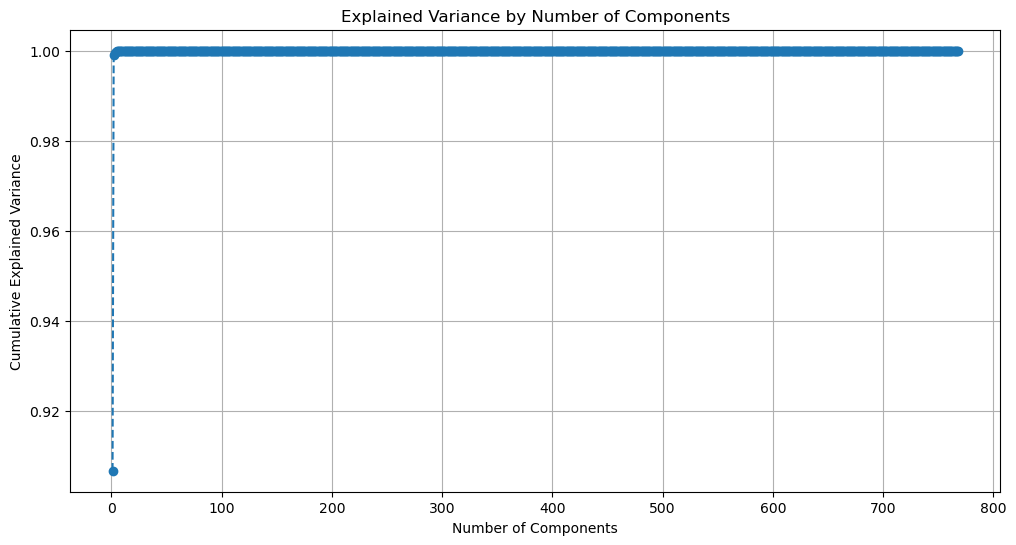

In [19]:
# Plot the explained variance ratio
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

In [20]:
# Choose the number of components that explain a significant amount of variance (e.g., 90%)
n_components = np.argmax(explained_variance_ratio >= 0.90) + 1
print(f"Number of components selected: {n_components}")

Number of components selected: 1


In [21]:
# Perform PCA with the selected number of components
pca = PCA(n_components=2)
reduced_projections = pca.fit_transform(predicted_features)

In [22]:
# Save PCA components and reduced projections
np.save("pca_components_97.npy", pca.components_)
#np.save("reduced_projections_66.npy", reduced_projections)

In [19]:
#pca_components = np.load("pca_components.npy")
#print(pca_components.shape)

(2, 768)


In [7]:
background_avg = np.load('background_avg_88.npy')
uninfected_avg = np.load('uninfected_avg_88.npy')
infected_avg = np.load('infected_avg_88.npy')

In [8]:
# Add PCA results and average mask values to the dataframe
df['PC1'] = reduced_projections[:, 0]
df['PC2'] = reduced_projections[:, 1]
df['Background Avg'] = background_avg
df['Uninfected Avg'] = uninfected_avg
df['Infected Avg'] = infected_avg

print(df.head())


  Row  Column  FOV  Cell ID  Timestep       PC1       PC2  Background Avg  \
0   A       3    0        1         2  0.446441 -0.111770        0.619106   
1   A       3    0       10        13  0.332164 -0.164421        0.628303   
2   A       3    0       11        21 -0.206133 -0.214614        0.741201   
3   A       3    0       12         8  0.404220 -0.133522        0.676976   
4   A       3    0       13        26  0.654043  0.037008        0.622009   

   Uninfected Avg  Infected Avg  
0        0.351677      0.029217  
1        0.343713      0.027985  
2        0.222098      0.036701  
3        0.252997      0.070028  
4        0.345434      0.032557  


In [138]:
# # Filter cells within the PC1 range of -0.5 to -0.25
# transitioning_cells_df = df[(df['PC1'] >= -0.5) & (df['PC1'] <= -0.25)]

# # Select only the required columns: row, column, FOV, cell ID, and timestep
# transitioning_cells_metadata = transitioning_cells_df[['Row', 'Column', 'FOV', 'Cell ID', 'Timestep']]

# # Print the metadata for the transitioning cells
# print(transitioning_cells_metadata)

# # Save the metadata to a new CSV file
# transitioning_cells_metadata.to_csv('transitioning_cells_metadata.csv', index=False)

     Row  Column  FOV  Cell ID  Timestep
8      A       3    0       17        36
14     A       3    0        3         4
21     A       3   10        1        23
32     A       3   10        2        44
46     A       3   10       32        19
...   ..     ...  ...      ...       ...
2554   B       4    8       19        12
2557   B       4    8       21        16
2577   B       4    8        6         0
2590   B       4    9       18        10
2595   B       4    9       22         5

[219 rows x 5 columns]


In [139]:
# import pandas as pd

# # Load the CSV files
# transitioning_cells_metadata_path = "/hpc/mydata/alishba.imran/VisCy/viscy/applications/contrastive_phenotyping/transitioning_cells_metadata.csv"
# final_track_timesteps_path = "/hpc/projects/intracellular_dashboard/viral-sensor/2024_02_04_A549_DENV_ZIKV_timelapse/6-patches/final_track_timesteps.csv"

# transitioning_cells_df = pd.read_csv(transitioning_cells_metadata_path)
# final_track_timesteps_df = pd.read_csv(final_track_timesteps_path)

# # Merge the dataframes on Row, Column, FOV, and Cell ID
# merged_df = pd.merge(
#     transitioning_cells_df,
#     final_track_timesteps_df,
#     on=['Row', 'Column', 'FOV', 'Cell ID'],
#     how='inner'
# )

# # Create a list to store the expanded rows
# expanded_rows = []

# # Iterate through the merged dataframe and create rows for each timestep
# for _, row in merged_df.iterrows():
#     start_time = row['Start Time']
#     end_time = row['End Time']
#     for t in range(start_time, end_time + 1):
#         expanded_rows.append({
#             'Row': row['Row'],
#             'Column': row['Column'],
#             'FOV': row['FOV'],
#             'Cell ID': row['Cell ID'],
#             'Timestep': t
#         })

# # Create a new dataframe from the expanded rows
# expanded_df = pd.DataFrame(expanded_rows)

# # Save the expanded dataframe to a new CSV file
# expanded_df.to_csv('/hpc/mydata/alishba.imran/VisCy/viscy/applications/expanded_transitioning_cells_metadata.csv', index=False)

# # Print the new dataframe to check
# print(expanded_df.head())


  Row  Column  FOV  Cell ID  Timestep
0   A       3    0       17        15
1   A       3    0       17        16
2   A       3    0       17        17
3   A       3    0       17        18
4   A       3    0       17        19


In [9]:
# Calculate rank correlations
correlations = []

for i in range(reduced_projections.shape[1]):
    pc = reduced_projections[:, i]
    
    background_corr, _ = spearmanr(pc, background_avg)
    uninfected_corr, _ = spearmanr(pc, uninfected_avg)
    infected_corr, _ = spearmanr(pc, infected_avg)
    
    correlations.append({
        "PC": i + 1,
        "Background Correlation": background_corr,
        "Uninfected Correlation": uninfected_corr,
        "Infected Correlation": infected_corr
    })

correlation_df = pd.DataFrame(correlations)
print(correlation_df)

   PC  Background Correlation  Uninfected Correlation  Infected Correlation
0   1               -0.160310                0.567283             -0.504108
1   2               -0.025629               -0.215784              0.256441


In [10]:
# Create interactive scatter plots for each average mask value
fig_background = px.scatter(df, x='PC1', y='PC2', color='Background Avg',
                            hover_data=['Row', 'Column', 'FOV', 'Cell ID', 'Timestep'])
fig_uninfected = px.scatter(df, x='PC1', y='PC2', color='Uninfected Avg',
                            hover_data=['Row', 'Column', 'FOV', 'Cell ID', 'Timestep'])
fig_infected = px.scatter(df, x='PC1', y='PC2', color='Infected Avg',
                          hover_data=['Row', 'Column', 'FOV', 'Cell ID', 'Timestep'])

# Show the plots
fig_background.show()
fig_uninfected.show()
fig_infected.show()

In [131]:
# Create an interactive scatter plot
fig = px.scatter(df, x='PC1', y='PC2', color='Infected Softmax Score',
                 hover_data=['Row', 'Column', 'FOV', 'Cell ID', 'Timestep'])

# Show the plot
fig.show()

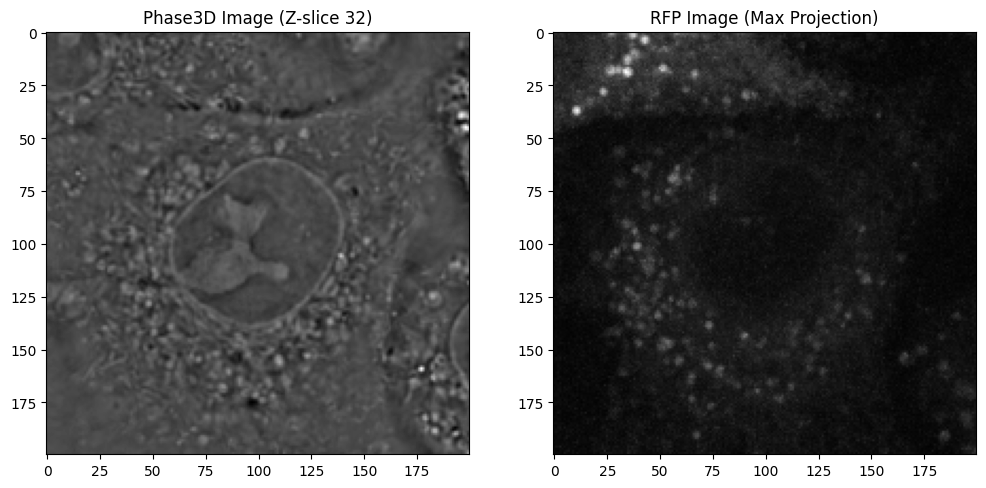

In [111]:
# Function to get cell data and plot the images

rfp_index = ds.channel_names.index('RFP')
phase3d_index = ds.channel_names.index('Phase3D')

def get_cell_data_and_plot(row, col, fov, cell_id, timestep):
    position_key = f"{row}/{col}/fov{fov}cell{cell_id}/0"
    zarr_array = ds[position_key]

    phase_img = zarr_array[timestep, phase3d_index, 32, :, :]
    rfp_img_max_proj = np.max(zarr_array[timestep, rfp_index, :, :, :], axis=0)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(phase_img, cmap='gray')
    axes[0].set_title('Phase3D Image (Z-slice 32)')
    axes[1].imshow(rfp_img_max_proj, cmap='gray')
    axes[1].set_title('RFP Image (Max Projection)')
    plt.show()

    return phase_img, rfp_img_max_proj

# example: get data for a specific cell and plot
row = 'B'
col = '3'
fov = 3
cell_id = 28
timestep = 30

phase_img, rfp_img = get_cell_data_and_plot(row, col, fov, cell_id, timestep)

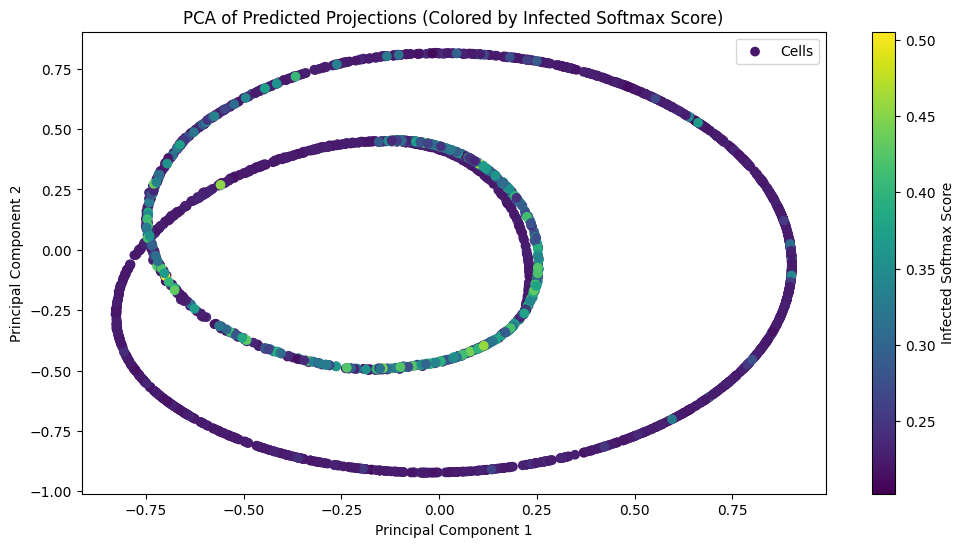

In [87]:
# Visualize the PCA results with cells colored based on their infected softmax scores
plt.figure(figsize=(12, 6))
sc = plt.scatter(reduced_projections[:, 0], reduced_projections[:, 1], c=infected_softmax, cmap='viridis', label='Cells')
plt.colorbar(sc, label='Infected Softmax Score')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Predicted Projections (Colored by Infected Softmax Score)')
plt.legend()
plt.show()

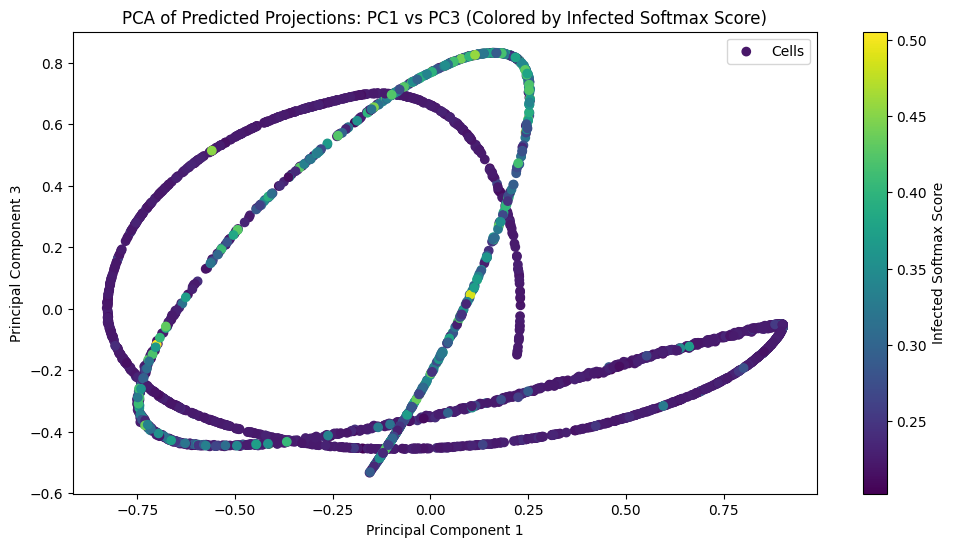

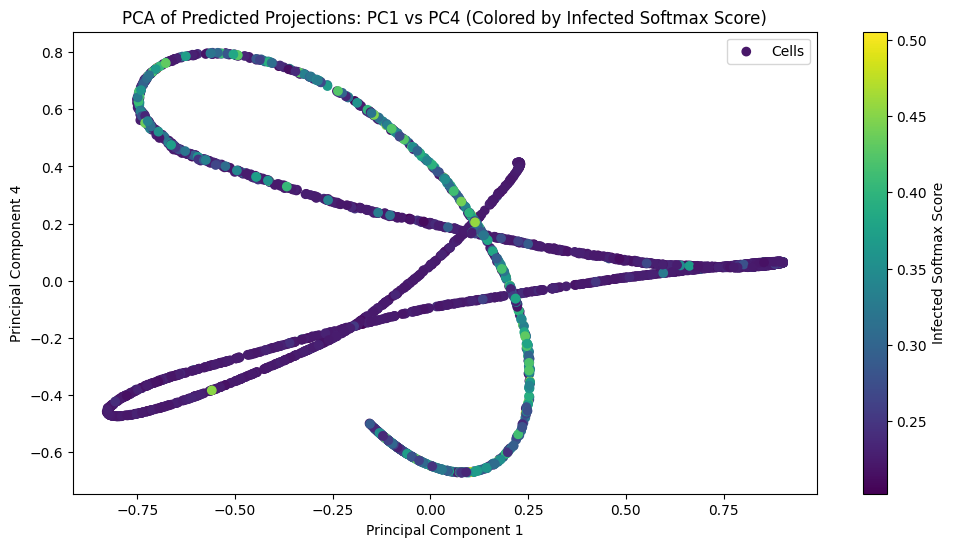

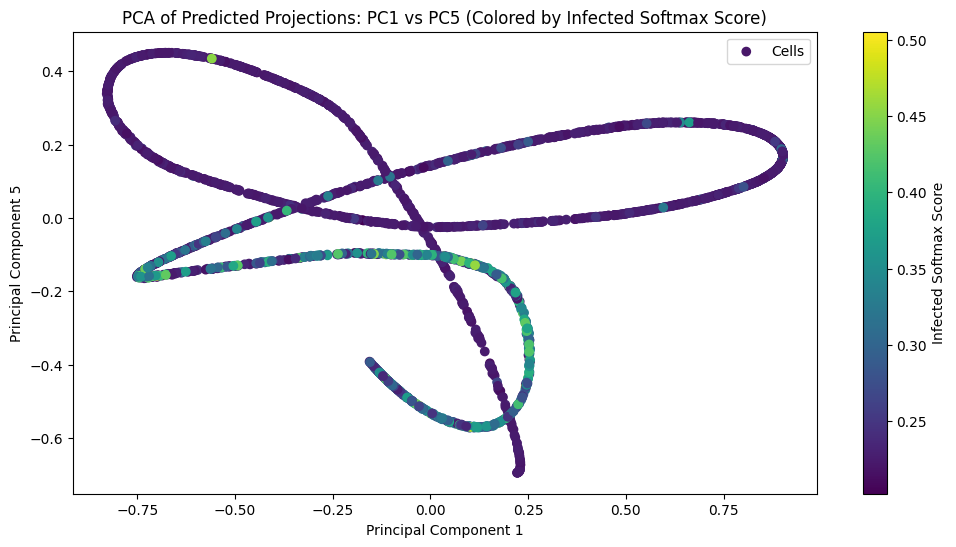

In [88]:
# PC1 vs PC3, PC1 vs PC4, etc.
n_components = 5
if n_components > 2:
    for i in range(2, n_components):
        plt.figure(figsize=(12, 6))
        sc = plt.scatter(reduced_projections[:, 0], reduced_projections[:, i], c=infected_softmax, cmap='viridis', label='Cells')
        plt.colorbar(sc, label='Infected Softmax Score')
        plt.xlabel('Principal Component 1')
        plt.ylabel(f'Principal Component {i + 1}')
        plt.title(f'PCA of Predicted Projections: PC1 vs PC{i + 1} (Colored by Infected Softmax Score)')
        plt.legend()
        plt.show()

In [20]:

correlations = np.zeros(n_components)
for i in range(n_components):
    pc = reduced_projections[:, i]
    correlation, _ = spearmanr(pc, infected_softmax)
    correlations[i] = correlation


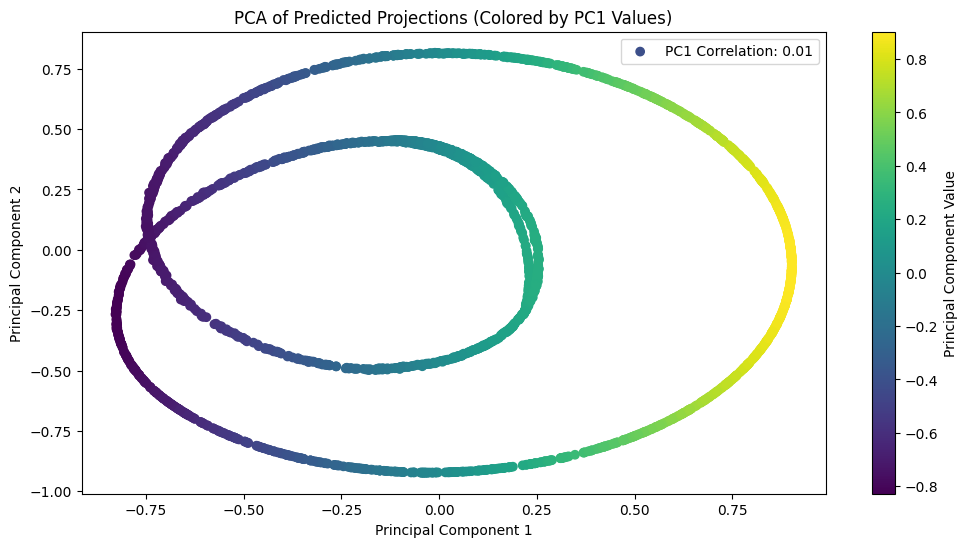

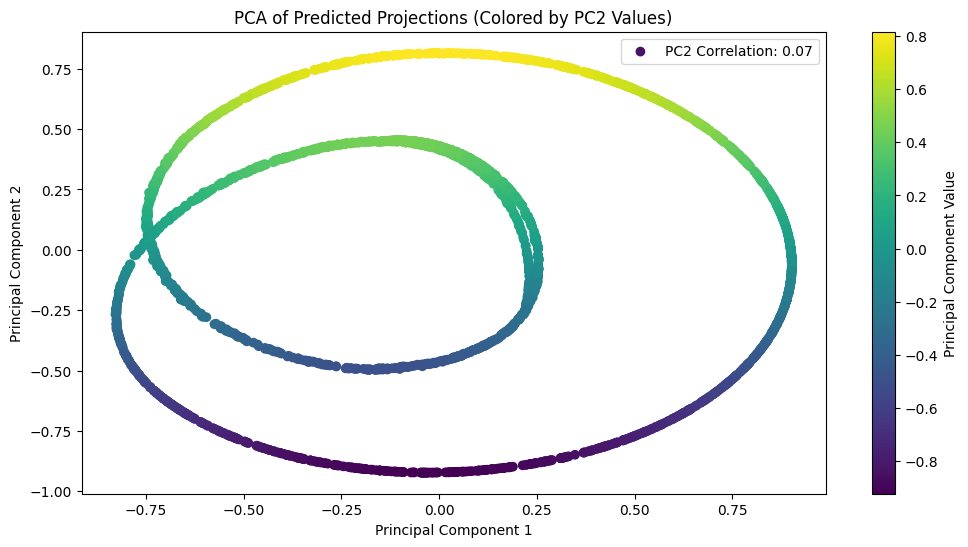

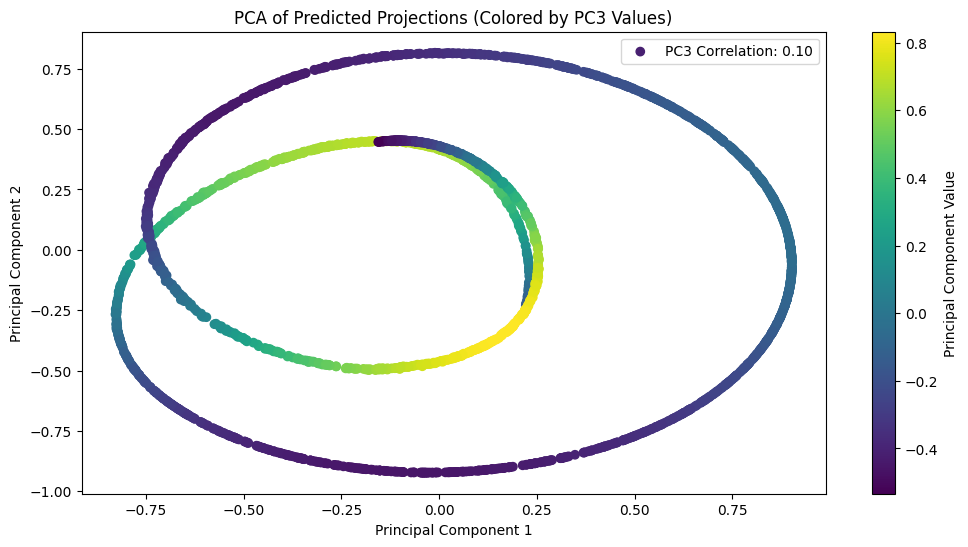

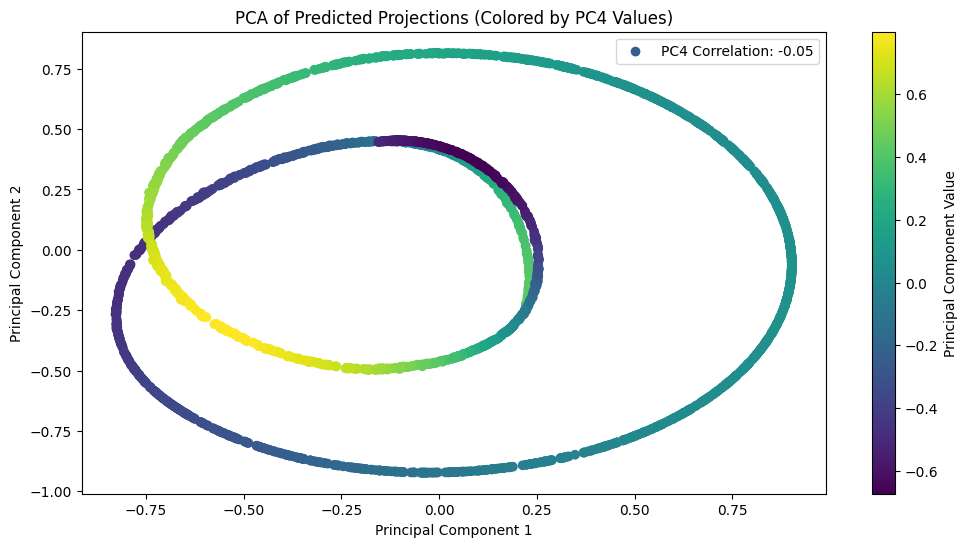

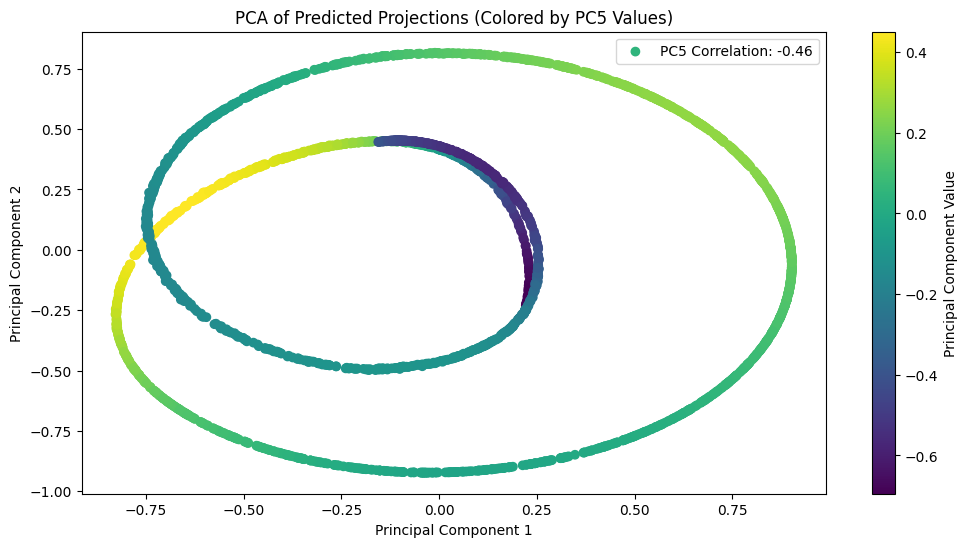

In [21]:
# Visualize the PCA results with cells colored based on their principal component values
for i in range(n_components):
    plt.figure(figsize=(12, 6))
    sc = plt.scatter(reduced_projections[:, 0], reduced_projections[:, 1], c=reduced_projections[:, i], cmap='viridis', label=f'PC{i+1} Correlation: {correlations[i]:.2f}')
    plt.colorbar(sc, label='Principal Component Value')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'PCA of Predicted Projections (Colored by PC{i+1} Values)')
    plt.legend()
    plt.show()

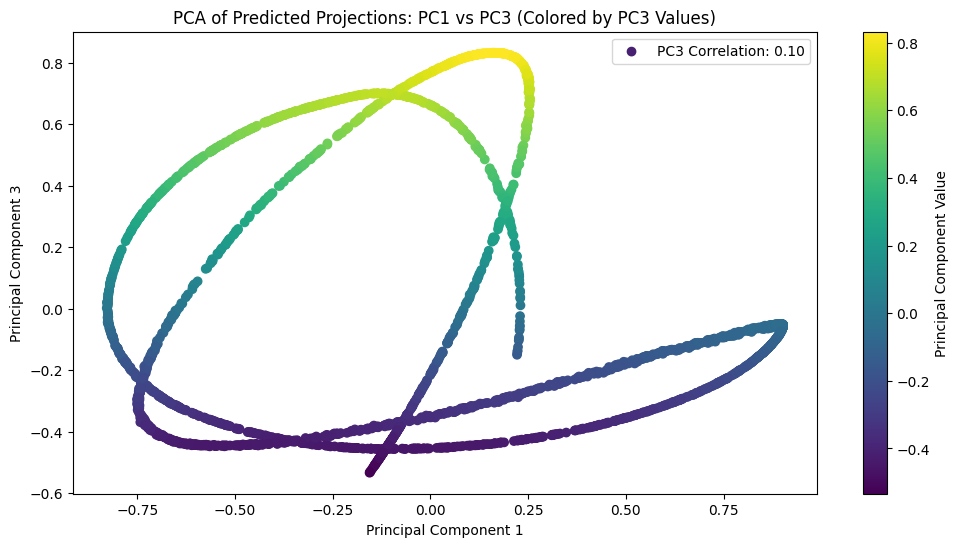

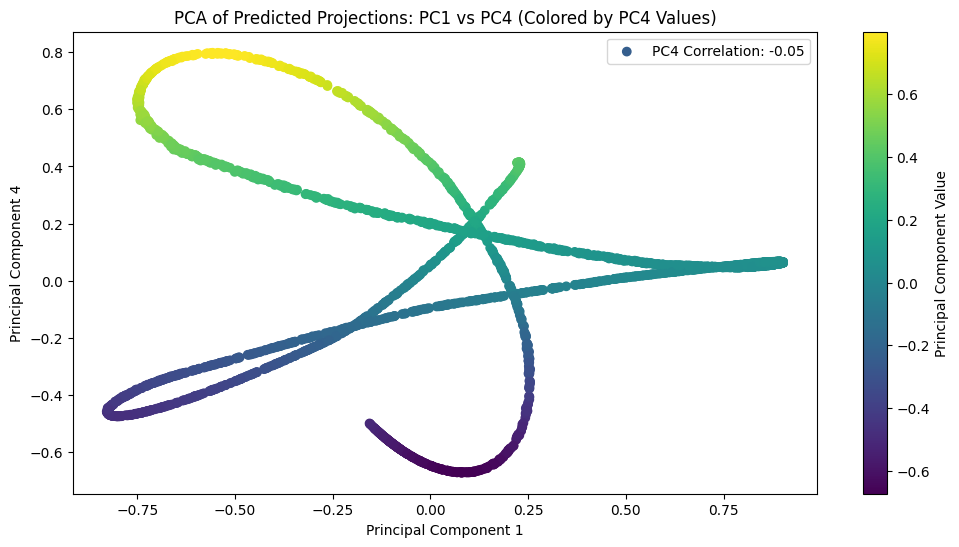

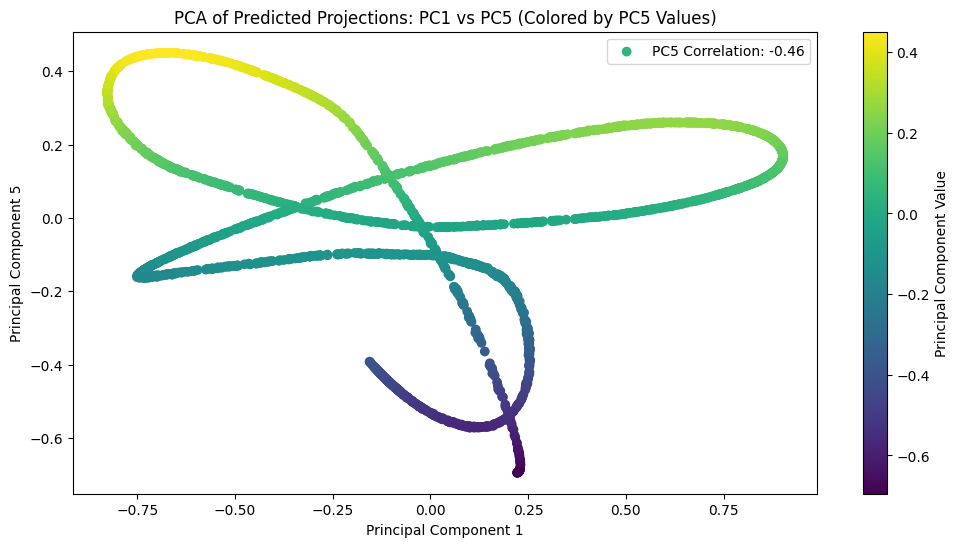

In [22]:
# Additional components if n_components > 2
if n_components > 2:
    for i in range(2, n_components):
        plt.figure(figsize=(12, 6))
        sc = plt.scatter(reduced_projections[:, 0], reduced_projections[:, i], c=reduced_projections[:, i], cmap='viridis', label=f'PC{i+1} Correlation: {correlations[i]:.2f}')
        plt.colorbar(sc, label='Principal Component Value')
        plt.xlabel('Principal Component 1')
        plt.ylabel(f'Principal Component {i + 1}')
        plt.title(f'PCA of Predicted Projections: PC1 vs PC{i + 1} (Colored by PC{i+1} Values)')
        plt.legend()
        plt.show()

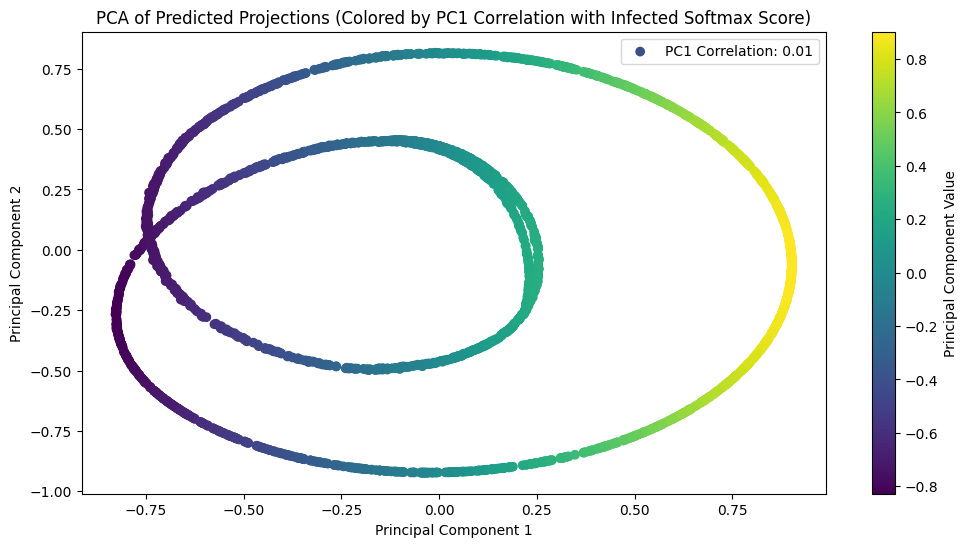

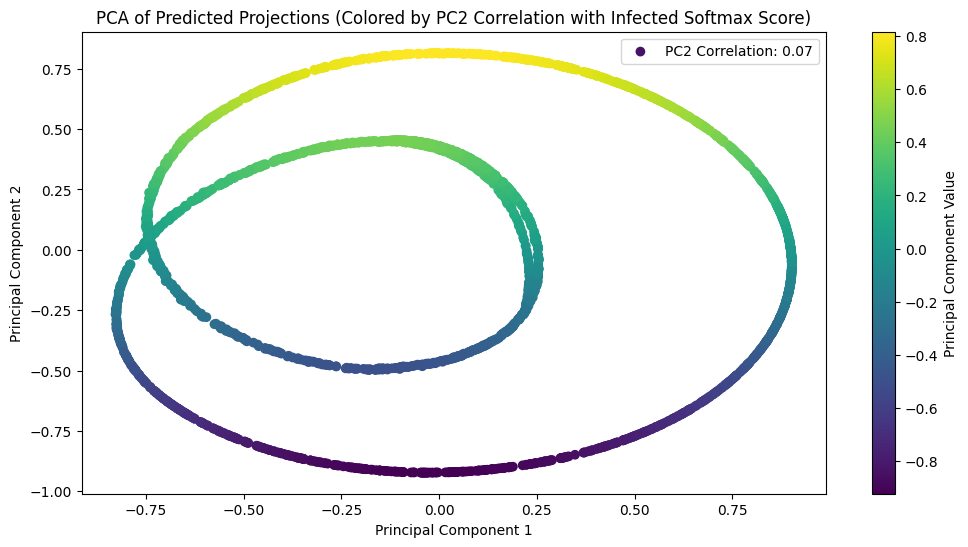

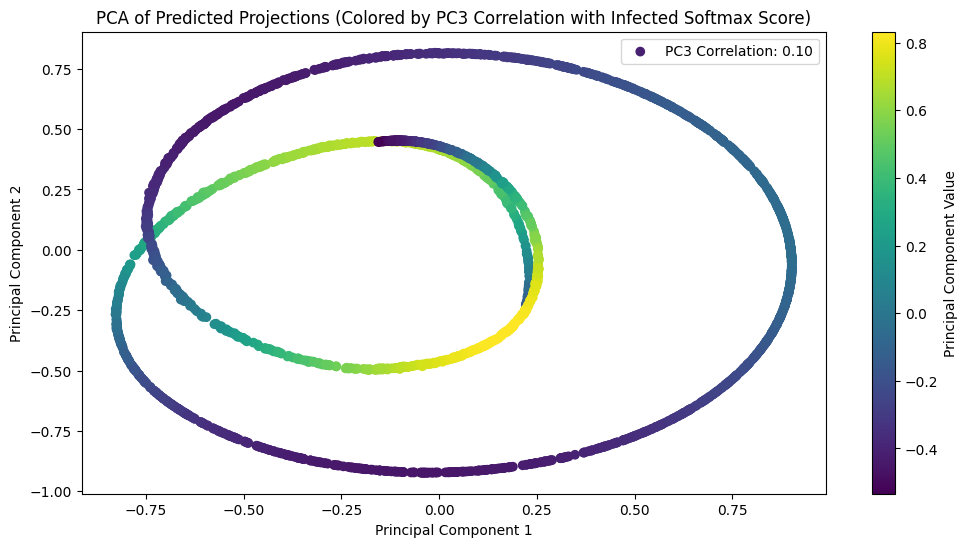

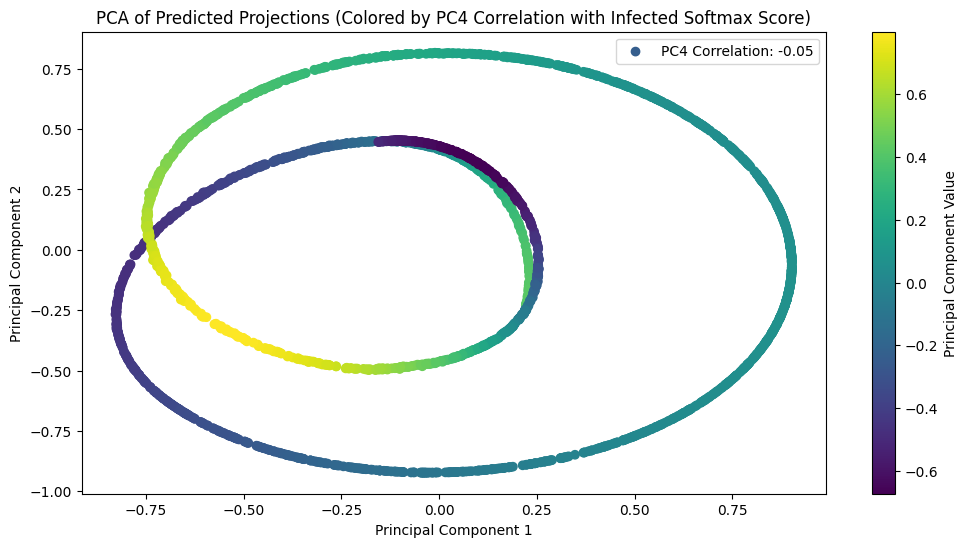

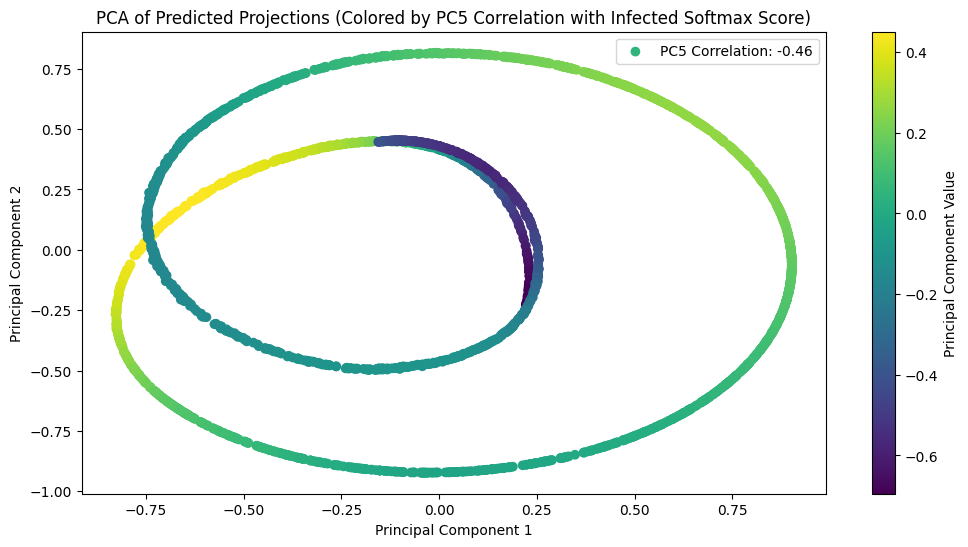

In [17]:

# Visualize the PCA results with color based on correlation with infected softmax score
for i in range(reduced_projections.shape[1]):
    pc = reduced_projections[:, i]
    infected_corr, _ = spearmanr(pc, infected_softmax)
    
    plt.figure(figsize=(12, 6))
    sc = plt.scatter(reduced_projections[:, 0], reduced_projections[:, 1], c=pc, cmap='viridis', label=f'PC{i+1} Correlation: {infected_corr:.2f}')
    plt.colorbar(sc, label='Principal Component Value')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'PCA of Predicted Projections (Colored by PC{i+1} Correlation with Infected Softmax Score)')
    plt.legend()
    plt.show()


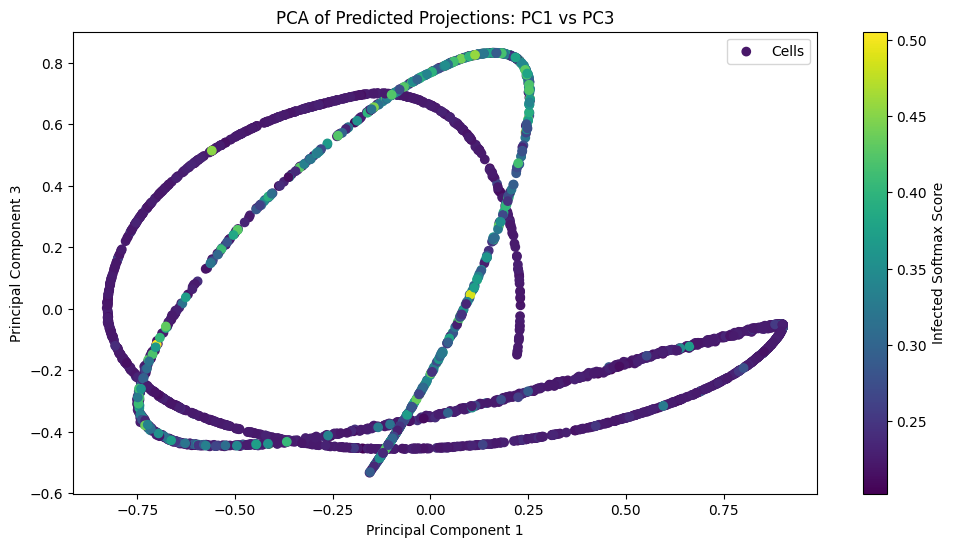

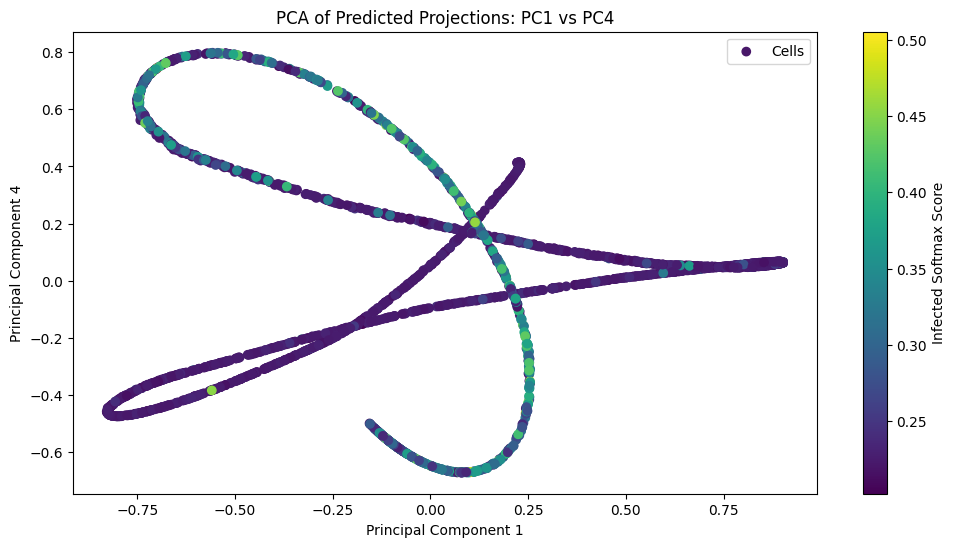

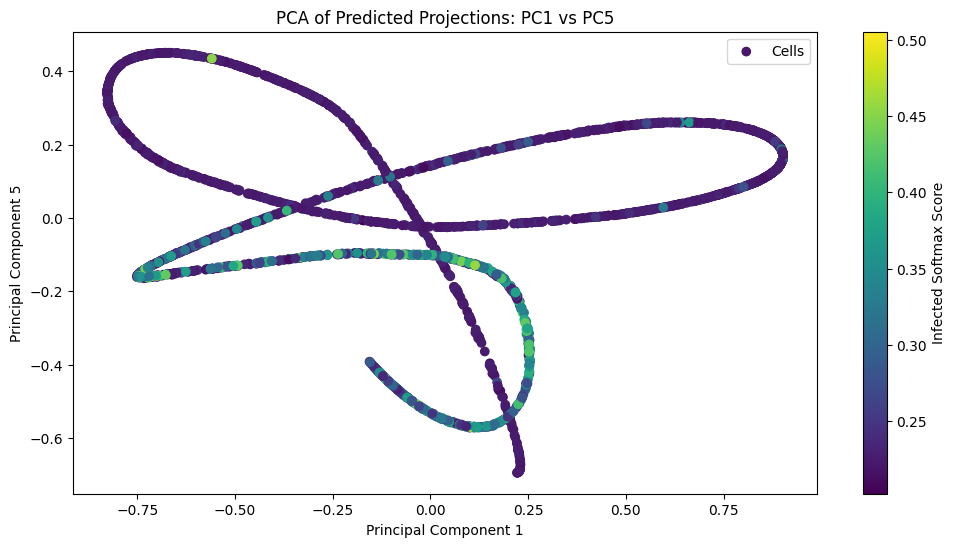

In [16]:
# Visualize additional PCs if needed
# PC1 vs PC3, PC1 vs PC4, etc.
if n_components > 2:
    for i in range(2, n_components):
        plt.figure(figsize=(12, 6))
        sc = plt.scatter(reduced_projections[:, 0], reduced_projections[:, i], c=infected_softmax, cmap='viridis', label='Cells')
        plt.colorbar(sc, label='Infected Softmax Score')
        plt.xlabel('Principal Component 1')
        plt.ylabel(f'Principal Component {i + 1}')
        plt.title(f'PCA of Predicted Projections: PC1 vs PC{i + 1}')
        plt.legend()
        plt.show()


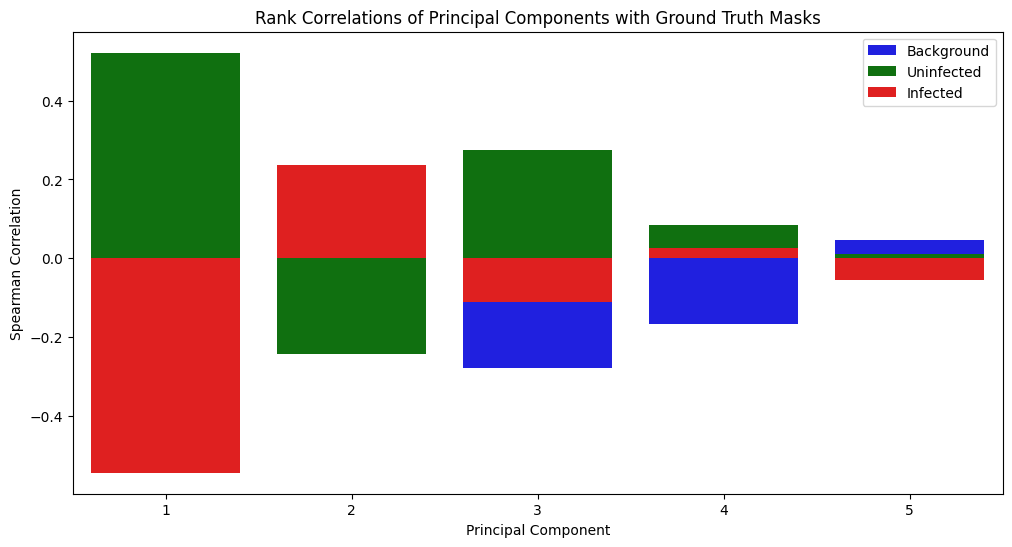

In [100]:
# Visualize the rank correlations
plt.figure(figsize=(12, 6))
sns.barplot(x="PC", y="Background Correlation", data=correlation_df, color='blue', label='Background')
sns.barplot(x="PC", y="Uninfected Correlation", data=correlation_df, color='green', label='Uninfected')
sns.barplot(x="PC", y="Infected Correlation", data=correlation_df, color='red', label='Infected')
plt.xlabel('Principal Component')
plt.ylabel('Spearman Correlation')
plt.title('Rank Correlations of Principal Components with Ground Truth Masks')
plt.legend()
plt.show()

TypeError: 'Axes' object is not iterable

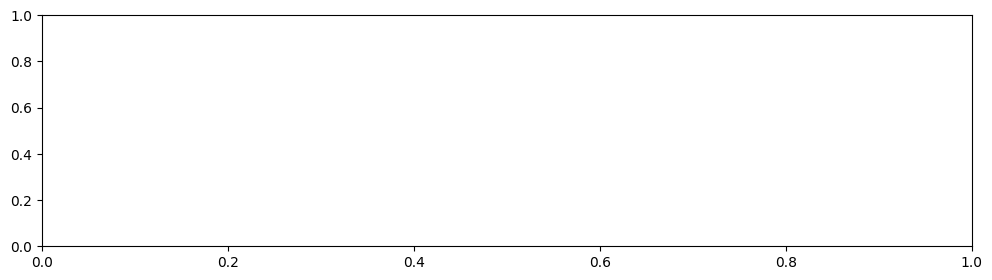

In [80]:
components = pca.components_

# Assuming your original features are named, you can list them
feature_names = [f"Feature {i}" for i in range(predicted_features.shape[1])]  # Replace with actual feature names if available

fig, axes = plt.subplots(n_components, 1, figsize=(12, 3 * n_components))
for i, (component, ax) in enumerate(zip(components[:n_components], axes)):
    sns.heatmap(component.reshape(1, -1), cmap='viridis', ax=ax, cbar=False, xticklabels=feature_names)
    ax.set_title(f'Principal Component {i + 1}')
    ax.set_xlabel('Features')
    ax.set_ylabel('Component Value')
plt.tight_layout()
plt.show()